In [37]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import trange
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.utils import shuffle

In [38]:
class CNN1D(nn.Module):
    def __init__(self, number_of_categories):
        super(CNN1D, self).__init__()
        # convolution layer
        # in_channels must be the same as the number of subcarriers, out_channels can be any value
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1)
        self.conv1d_2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1)
        self.conv1d_3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.averagepool = nn.AvgPool1d(kernel_size=2)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(64)
        self.batch_norm_2 = nn.BatchNorm1d(128)
        self.batch_norm_3 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout1d(p=0.2)
        

        # calculate the in_features
        self.fc1 = nn.Linear(in_features=512, out_features=128)
        # self.fc1 = nn.Linear(in_features=120, out_features=90)
        self.fc2 = nn.Linear(in_features=128, out_features=number_of_categories)

    def forward(self, x):
        # input tensor size [batch_size, 64 (features), 40 (sequence length)]
        x = self.conv1d(x)
        # # [batch_size, 64 (features), 40 (sequence length)]
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.averagepool(x)
        
        x = self.conv1d_2(x)
        # # [batch_size, 64 (features), 40 (sequence length)]
        x = self.batch_norm_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.averagepool(x)
        
        x = self.conv1d_3(x)
        # # [batch_size, 64 (features), 40 (sequence length)]
        x = self.batch_norm_3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.averagepool(x)
        
        x = x.view(-1, x.shape[1] * x.shape[2])  # Adjust the input size based on the output size after convolutions and pooling\
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [39]:
test = np.random.rand(40, )
x = torch.tensor(test, dtype=torch.float32)
print(test.shape)
test = x.unsqueeze(0)
print(test)
testing = np.random.rand(64, 1, 40 )
new = np.random.rand(1, 40)
print(new)
x = torch.tensor(testing, dtype=torch.float32)
conv1d = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1)
conv1d_2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1)
conv1d_3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1)
maxpool = nn.MaxPool1d(kernel_size=2)
dropout = nn.Dropout1d(p=0.5)
flatten = nn.Flatten(0)

relu = nn.ReLU()

# calculate the in_features
fc1 = nn.Linear(in_features=256 * 3, out_features=128)
# self.fc1 = nn.Linear(in_features=120, out_features=90)
fc2 = nn.Linear(in_features=128, out_features=10)

x = conv1d(x)
# [batch_size, 64 (features), 40 (sequence length)]
x = relu(x)
x = maxpool(x)
print(x.shape)
x = dropout(x)
x = conv1d_2(x)
# [batch_size, 64 (features), 40 (sequence length)]
x = relu(x)
x = maxpool(x)
print(x.shape)
x = dropout(x)
x = conv1d_3(x)
# [batch_size, 64 (features), 40 (sequence length)]
x = relu(x)
x = maxpool(x)
print(x.shape)
x = dropout(x)
x = x.view(-1, x.shape[1] * x.shape[2])  # Adjust the input size based on the output size after convolutions and pooling

print(x.shape)
x = fc1(x)
x = relu(x)
x = fc2(x)

(40,)
tensor([[0.7197, 0.7572, 0.4681, 0.6233, 0.8954, 0.4450, 0.4658, 0.7184, 0.1483,
         0.8780, 0.0281, 0.9372, 0.0845, 0.5361, 0.9564, 0.9884, 0.1002, 0.1932,
         0.7501, 0.5961, 0.6244, 0.9727, 0.6195, 0.8510, 0.3867, 0.5823, 0.2868,
         0.7374, 0.3377, 0.2603, 0.7761, 0.6468, 0.8062, 0.9862, 0.6617, 0.1710,
         0.5571, 0.3049, 0.1252, 0.0587]])
[[0.26964339 0.43609281 0.24542345 0.85425258 0.67960265 0.31184892
  0.91593076 0.94276759 0.9105828  0.4601889  0.07850866 0.24959941
  0.35714063 0.2949428  0.23012592 0.01745157 0.52208734 0.84859795
  0.42353635 0.82834925 0.09619327 0.49733456 0.34184761 0.49724744
  0.25007448 0.27798808 0.86142439 0.84670697 0.06980615 0.53834209
  0.42646461 0.88950725 0.84886396 0.47910282 0.61186169 0.8183994
  0.47364937 0.09505448 0.96913937 0.77711634]]
torch.Size([64, 64, 19])
torch.Size([64, 128, 8])
torch.Size([64, 256, 3])
torch.Size([64, 768])


In [40]:
class CSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [41]:
def importData():
    X_train, X_val, X_test, y_train, y_val, y_test = [], [], [], [], [], []
    for i in range(10):
        temp_train = np.load(f'../data/windtalker_steps/{i}_table_train.npy')
        temp_val = np.load(f'../data/windtalker_steps/{i}_table_val.npy')
        temp_test = np.load(f'../data/windtalker_steps/{i}_table_test.npy')
        if i == 0:
            X_train = temp_train
            X_val = temp_val
            X_test = temp_test
            y_train = np.array([[i] for _ in range(X_train.shape[0])])
            y_val = np.array([[i] for _ in range(X_val.shape[0])])
            y_test = np.array([[i] for _ in range(X_test.shape[0])])
        else:
            X_train = np.append(X_train, temp_train, axis=0)
            X_val = np.append(X_val, temp_val, axis=0)
            X_test = np.append(X_test, temp_test, axis=0)
            y_train = np.append(y_train, np.array([[i] for _ in range(temp_train.shape[0])]), axis=0)
            y_val = np.append(y_val, np.array([[i] for _ in range(temp_val.shape[0])]), axis=0)
            y_test = np.append(y_test, np.array([[i] for _ in range(temp_test.shape[0])]), axis=0)
            
    return X_train, X_val, X_test, y_train, y_val, y_test

In [42]:
class RunningAverage:
    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        return self.total / float(self.steps)

def accuracy(outputs, labels):
    # outputs (predicted), labels (true)
    outputs = np.argmax(outputs.cpu().detach().numpy(), axis=1)
    labels = labels.squeeze()
    # compare outputs with labels
    return np.sum([1 if first == second else 0 for first, second in zip(labels, outputs)]) / float(len(labels))

In [43]:
def train(model, optimizer, trainLoader, loss_fn, iterations):
    model.train()
    train_loss = RunningAverage()
    train_acc = RunningAverage()
    
    with trange(iterations) as pbar:
        for X_batch, y_batch in trainLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss.update(loss)
            train_acc.update(accuracy(y_pred, y_batch))
            pbar.update(1)
            
    return train_loss(), train_acc()
    
def eval(model, valLoader, loss_fn):
    model.eval()
    eval_loss = RunningAverage()
    eval_acc = RunningAverage()
    
    with torch.no_grad():
        for X_batch, y_batch in valLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            
            eval_loss.update(loss)
            eval_acc.update(accuracy(y_pred, y_batch))
            
    return eval_loss(), eval_acc()
    
def test(model, testLoader, test_size):
    model.eval()
    for X_batch, y_batch in testLoader:
        y_batch = y_batch.type(torch.LongTensor).squeeze(1)
        logits = model(X_batch)
        y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
        
    print(f"Overall Accuracy: {accuracy(y_pred, y_batch):.3f}")

    # True positive percentage
    percentages = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
    # outputs (predicted), labels (true)
    outputs = np.argmax(y_pred.cpu().detach().numpy(), axis=1)
    labels = y_batch.squeeze()
    
    for i in range(len(outputs)):
        if outputs[i] == labels[i]:
            percentages[outputs[i]] += 1
    
    # plot the percentages of correct predictions
    y_percent = [(value/(test_size/10))*100 for key, value in percentages.items()]
    x_label = [str(key) for key, _ in percentages.items()]
    
    fig, test = plt.subplots(figsize=(10,6))
    test.bar(x_label, y_percent)
    test.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Key")
    plt.title("Accuracy (%) per key")
    plt.savefig("percentage_correct_denoised_butter.png", bbox_inches='tight')
    plt.show()
    
    cm = confusion_matrix(y_true=labels, y_pred=outputs)
    cm = np.divide(cm, (test_size/10))
    
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig("confusion_matrix_denoised_butter.png", bbox_inches='tight')
    plt.show()
    
    print(f"Accuracy for each key: {''.join([x + ': ' + str(round(y, 3)) + '% ' for x, y in zip(x_label, y_percent)])}")
    
    print(classification_report(y_true=labels, y_pred=outputs, target_names=x_label))

In [44]:
def train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss_fn, iterations):
    # for plotting the loss and accuracy
    train_loss_list, train_acc_list, eval_loss_list, eval_acc_list  = [], [], [], []
        
    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer, trainLoader, loss_fn, iterations)
        eval_loss, eval_acc = eval(model, valLoader, loss_fn)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        eval_loss_list.append(eval_loss)
        eval_acc_list.append(eval_acc)
        
        print(f"Train: Epoch {epoch}: Loss {train_loss}, Accuracy {train_acc}")
        print(f"Eval: Epoch {epoch}: Loss {eval_loss}, Accuracy {eval_acc}")
        
    return train_loss_list, train_acc_list, eval_loss_list, eval_acc_list
        

In [45]:
def plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs):
    x = [i for i in range(1, epochs+1)]
    
    fig, loss = plt.subplots(figsize=(10,6))
    loss.plot(x, [trainLoss.item() for trainLoss in train_loss_list], label="Training Loss")
    loss.plot(x, [evalLoss.item() for evalLoss in eval_loss_list], label="Validation Loss")
    plt.legend()
    plt.ylabel("Average Loss")
    plt.xlabel("Epochs")
    plt.title("Average Loss per epoch")
    plt.savefig("loss_per_epoch_denoised_butter.png", bbox_inches='tight')
    
    plt.show()
    
    fig, acc = plt.subplots(figsize=(10,6))
    acc.plot(x, [trainAcc.item() for trainAcc in train_acc_list], label="Training Accuracy")
    acc.plot(x, [evalAcc.item() for evalAcc in eval_acc_list], label="Validation Accuracy")
    plt.legend()
    plt.ylabel("Average Accuracy")
    plt.xlabel("Epochs")
    plt.title("Average Accuracy per epoch")
    plt.savefig("acc_per_epoch_denoised_butter.png", bbox_inches='tight')
    plt.show()

In [46]:
def print_model_parameters(model):
    total_parameters = 0
    print(" "*20 + "Model Parameters" + " "*20)
    print("="*57)
    print(f"{'Layer':<25}" + "| Parameters")
    print("="*57)
    for name, param in model.named_parameters():
        temp = 1
        temp_list = []
        if param.requires_grad:
            print(f"{name:<25}", end="")
            for i in param.data.shape:
                temp *= i
                temp_list.append(str(i))
            print(": ", end="")
            if len(temp_list) > 1:
                print(f"{' * '.join(temp_list)}", end="")
                print(" = " + str(temp))
            else:
                print(f"{''.join(temp_list)}")

        total_parameters += temp
        
    print("="*57)
    print(f"{'Total parameters':<25}" + f": {total_parameters}")
    print("="*57)

100%|██████████| 55/55 [00:01<00:00, 40.83it/s]


Train: Epoch 0: Loss 2.3226819038391113, Accuracy 0.09555785123966942
Eval: Epoch 0: Loss 2.3048458099365234, Accuracy 0.1205078125


100%|██████████| 55/55 [00:01<00:00, 44.61it/s]


Train: Epoch 1: Loss 2.3053367137908936, Accuracy 0.10294421487603306
Eval: Epoch 1: Loss 2.304208993911743, Accuracy 0.105078125


100%|██████████| 55/55 [00:01<00:00, 47.45it/s]


Train: Epoch 2: Loss 2.3012566566467285, Accuracy 0.1097107438016529
Eval: Epoch 2: Loss 2.305727243423462, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 41.57it/s]


Train: Epoch 3: Loss 2.3016347885131836, Accuracy 0.11686466942148761
Eval: Epoch 3: Loss 2.305851697921753, Accuracy 0.109765625


100%|██████████| 55/55 [00:01<00:00, 46.03it/s]


Train: Epoch 4: Loss 2.296522378921509, Accuracy 0.12295971074380165
Eval: Epoch 4: Loss 2.307521343231201, Accuracy 0.103125


100%|██████████| 55/55 [00:01<00:00, 38.17it/s]


Train: Epoch 5: Loss 2.294826030731201, Accuracy 0.11557334710743801
Eval: Epoch 5: Loss 2.3037400245666504, Accuracy 0.1109375


100%|██████████| 55/55 [00:01<00:00, 44.11it/s]


Train: Epoch 6: Loss 2.2906811237335205, Accuracy 0.11738119834710745
Eval: Epoch 6: Loss 2.309424638748169, Accuracy 0.107421875


100%|██████████| 55/55 [00:01<00:00, 37.72it/s]


Train: Epoch 7: Loss 2.28609561920166, Accuracy 0.1253873966942149
Eval: Epoch 7: Loss 2.3088653087615967, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 41.35it/s]


Train: Epoch 8: Loss 2.2825510501861572, Accuracy 0.12647210743801654
Eval: Epoch 8: Loss 2.3110392093658447, Accuracy 0.1091796875


100%|██████████| 55/55 [00:01<00:00, 37.01it/s]


Train: Epoch 9: Loss 2.278067111968994, Accuracy 0.13205061983471075
Eval: Epoch 9: Loss 2.3125412464141846, Accuracy 0.113671875


100%|██████████| 55/55 [00:01<00:00, 47.91it/s]


Train: Epoch 10: Loss 2.274005889892578, Accuracy 0.1400051652892562
Eval: Epoch 10: Loss 2.326441764831543, Accuracy 0.1125


100%|██████████| 55/55 [00:01<00:00, 46.45it/s]


Train: Epoch 11: Loss 2.270763635635376, Accuracy 0.1331353305785124
Eval: Epoch 11: Loss 2.3151514530181885, Accuracy 0.1150390625


100%|██████████| 55/55 [00:01<00:00, 45.05it/s]


Train: Epoch 12: Loss 2.270291805267334, Accuracy 0.1409349173553719
Eval: Epoch 12: Loss 2.318991184234619, Accuracy 0.1052734375


100%|██████████| 55/55 [00:01<00:00, 48.46it/s]


Train: Epoch 13: Loss 2.2641677856445312, Accuracy 0.14338842975206612
Eval: Epoch 13: Loss 2.3251078128814697, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 49.73it/s]


Train: Epoch 14: Loss 2.256894588470459, Accuracy 0.15896177685950413
Eval: Epoch 14: Loss 2.322155714035034, Accuracy 0.10546875


100%|██████████| 55/55 [00:01<00:00, 47.74it/s]


Train: Epoch 15: Loss 2.253298282623291, Accuracy 0.1540805785123967
Eval: Epoch 15: Loss 2.324671983718872, Accuracy 0.1142578125


100%|██████████| 55/55 [00:01<00:00, 49.82it/s]


Train: Epoch 16: Loss 2.2467710971832275, Accuracy 0.15547520661157024
Eval: Epoch 16: Loss 2.332385540008545, Accuracy 0.110546875


100%|██████████| 55/55 [00:01<00:00, 50.60it/s]


Train: Epoch 17: Loss 2.2449657917022705, Accuracy 0.15049070247933885
Eval: Epoch 17: Loss 2.3328640460968018, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 47.78it/s]


Train: Epoch 18: Loss 2.2373273372650146, Accuracy 0.1740444214876033
Eval: Epoch 18: Loss 2.3384063243865967, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 47.74it/s]


Train: Epoch 19: Loss 2.2293715476989746, Accuracy 0.17104855371900826
Eval: Epoch 19: Loss 2.3464646339416504, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 42.05it/s]


Train: Epoch 20: Loss 2.2243258953094482, Accuracy 0.18104338842975207
Eval: Epoch 20: Loss 2.3487155437469482, Accuracy 0.1173828125


100%|██████████| 55/55 [00:01<00:00, 43.89it/s]


Train: Epoch 21: Loss 2.2166552543640137, Accuracy 0.18336776859504134
Eval: Epoch 21: Loss 2.3530774116516113, Accuracy 0.1091796875


100%|██████████| 55/55 [00:01<00:00, 46.30it/s]


Train: Epoch 22: Loss 2.2145638465881348, Accuracy 0.17972623966942147
Eval: Epoch 22: Loss 2.3665950298309326, Accuracy 0.1103515625


100%|██████████| 55/55 [00:01<00:00, 49.20it/s]


Train: Epoch 23: Loss 2.204256057739258, Accuracy 0.18579545454545454
Eval: Epoch 23: Loss 2.360753059387207, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 48.82it/s]


Train: Epoch 24: Loss 2.198850154876709, Accuracy 0.19052169421487603
Eval: Epoch 24: Loss 2.3742167949676514, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 48.33it/s]


Train: Epoch 25: Loss 2.191701650619507, Accuracy 0.19679752066115702
Eval: Epoch 25: Loss 2.3637351989746094, Accuracy 0.105078125


100%|██████████| 55/55 [00:01<00:00, 45.42it/s]


Train: Epoch 26: Loss 2.1857924461364746, Accuracy 0.2024535123966942
Eval: Epoch 26: Loss 2.382678747177124, Accuracy 0.1021484375


100%|██████████| 55/55 [00:01<00:00, 45.99it/s]


Train: Epoch 27: Loss 2.1661133766174316, Accuracy 0.2053460743801653
Eval: Epoch 27: Loss 2.380138874053955, Accuracy 0.0912109375


100%|██████████| 55/55 [00:01<00:00, 41.17it/s]


Train: Epoch 28: Loss 2.165057897567749, Accuracy 0.20384814049586775
Eval: Epoch 28: Loss 2.3851451873779297, Accuracy 0.1052734375


100%|██████████| 55/55 [00:01<00:00, 39.63it/s]


Train: Epoch 29: Loss 2.1581294536590576, Accuracy 0.2172004132231405
Eval: Epoch 29: Loss 2.4026825428009033, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 40.71it/s]


Train: Epoch 30: Loss 2.1475563049316406, Accuracy 0.21523760330578512
Eval: Epoch 30: Loss 2.3946127891540527, Accuracy 0.1060546875


100%|██████████| 55/55 [00:01<00:00, 37.14it/s]


Train: Epoch 31: Loss 2.1417486667633057, Accuracy 0.22471590909090908
Eval: Epoch 31: Loss 2.4185643196105957, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 34.87it/s]


Train: Epoch 32: Loss 2.132371425628662, Accuracy 0.22536157024793388
Eval: Epoch 32: Loss 2.4225974082946777, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 37.34it/s]


Train: Epoch 33: Loss 2.116647720336914, Accuracy 0.2254132231404959
Eval: Epoch 33: Loss 2.4084208011627197, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 40.59it/s]


Train: Epoch 34: Loss 2.111229181289673, Accuracy 0.23321280991735535
Eval: Epoch 34: Loss 2.441385507583618, Accuracy 0.11640625


100%|██████████| 55/55 [00:01<00:00, 43.82it/s]


Train: Epoch 35: Loss 2.1029655933380127, Accuracy 0.23879132231404956
Eval: Epoch 35: Loss 2.4315168857574463, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 41.73it/s]


Train: Epoch 36: Loss 2.0929229259490967, Accuracy 0.2381456611570248
Eval: Epoch 36: Loss 2.432112693786621, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 44.53it/s]


Train: Epoch 37: Loss 2.082212209701538, Accuracy 0.24196797520661156
Eval: Epoch 37: Loss 2.4385836124420166, Accuracy 0.105078125


100%|██████████| 55/55 [00:01<00:00, 47.01it/s]


Train: Epoch 38: Loss 2.076334238052368, Accuracy 0.24927685950413225
Eval: Epoch 38: Loss 2.4590718746185303, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 48.29it/s]


Train: Epoch 39: Loss 2.0646464824676514, Accuracy 0.2524276859504132
Eval: Epoch 39: Loss 2.4829938411712646, Accuracy 0.0900390625


100%|██████████| 55/55 [00:01<00:00, 45.42it/s]


Train: Epoch 40: Loss 2.054018020629883, Accuracy 0.2577995867768595
Eval: Epoch 40: Loss 2.4867608547210693, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 46.03it/s]


Train: Epoch 41: Loss 2.050170421600342, Accuracy 0.2520402892561983
Eval: Epoch 41: Loss 2.485456943511963, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 41.47it/s]


Train: Epoch 42: Loss 2.0368361473083496, Accuracy 0.2616735537190083
Eval: Epoch 42: Loss 2.4612860679626465, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 40.71it/s]


Train: Epoch 43: Loss 2.0182387828826904, Accuracy 0.27685950413223137
Eval: Epoch 43: Loss 2.4939215183258057, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 43.07it/s]


Train: Epoch 44: Loss 2.0033068656921387, Accuracy 0.2838068181818182
Eval: Epoch 44: Loss 2.5142440795898438, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 45.68it/s]


Train: Epoch 45: Loss 2.001340627670288, Accuracy 0.278150826446281
Eval: Epoch 45: Loss 2.502509593963623, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 47.25it/s]


Train: Epoch 46: Loss 1.9989770650863647, Accuracy 0.2753099173553719
Eval: Epoch 46: Loss 2.513057231903076, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 48.50it/s]


Train: Epoch 47: Loss 1.9805525541305542, Accuracy 0.28352272727272726
Eval: Epoch 47: Loss 2.53771710395813, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 46.41it/s]


Train: Epoch 48: Loss 1.9685636758804321, Accuracy 0.2870092975206612
Eval: Epoch 48: Loss 2.5355026721954346, Accuracy 0.10703125


100%|██████████| 55/55 [00:01<00:00, 44.31it/s]


Train: Epoch 49: Loss 1.9456872940063477, Accuracy 0.3029700413223141
Eval: Epoch 49: Loss 2.5486299991607666, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 41.67it/s]


Train: Epoch 50: Loss 1.93845796585083, Accuracy 0.309504132231405
Eval: Epoch 50: Loss 2.5641064643859863, Accuracy 0.106640625


100%|██████████| 55/55 [00:01<00:00, 46.77it/s]


Train: Epoch 51: Loss 1.922403335571289, Accuracy 0.3100464876033058
Eval: Epoch 51: Loss 2.5769190788269043, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 47.70it/s]


Train: Epoch 52: Loss 1.914703607559204, Accuracy 0.3198088842975207
Eval: Epoch 52: Loss 2.5952913761138916, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 47.70it/s]


Train: Epoch 53: Loss 1.9089667797088623, Accuracy 0.3119318181818182
Eval: Epoch 53: Loss 2.588216781616211, Accuracy 0.087890625


100%|██████████| 55/55 [00:01<00:00, 48.98it/s]


Train: Epoch 54: Loss 1.8877357244491577, Accuracy 0.32507747933884296
Eval: Epoch 54: Loss 2.613839864730835, Accuracy 0.091015625


100%|██████████| 55/55 [00:01<00:00, 48.25it/s]


Train: Epoch 55: Loss 1.8848756551742554, Accuracy 0.3311466942148761
Eval: Epoch 55: Loss 2.623082399368286, Accuracy 0.10859375


100%|██████████| 55/55 [00:01<00:00, 48.50it/s]


Train: Epoch 56: Loss 1.8701225519180298, Accuracy 0.33393595041322316
Eval: Epoch 56: Loss 2.6413495540618896, Accuracy 0.0908203125


100%|██████████| 55/55 [00:01<00:00, 44.50it/s]


Train: Epoch 57: Loss 1.84963059425354, Accuracy 0.34039256198347106
Eval: Epoch 57: Loss 2.6706082820892334, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 47.83it/s]


Train: Epoch 58: Loss 1.8522852659225464, Accuracy 0.33737086776859504
Eval: Epoch 58: Loss 2.6845316886901855, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 47.78it/s]


Train: Epoch 59: Loss 1.8385281562805176, Accuracy 0.34591942148760335
Eval: Epoch 59: Loss 2.6627087593078613, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 44.93it/s]


Train: Epoch 60: Loss 1.8103790283203125, Accuracy 0.3475206611570248
Eval: Epoch 60: Loss 2.697122573852539, Accuracy 0.105859375


100%|██████████| 55/55 [00:01<00:00, 46.26it/s]


Train: Epoch 61: Loss 1.8082276582717896, Accuracy 0.3596074380165289
Eval: Epoch 61: Loss 2.7047884464263916, Accuracy 0.10625


100%|██████████| 55/55 [00:01<00:00, 48.93it/s]


Train: Epoch 62: Loss 1.7826234102249146, Accuracy 0.37011880165289257
Eval: Epoch 62: Loss 2.702930450439453, Accuracy 0.108203125


100%|██████████| 55/55 [00:01<00:00, 45.95it/s]


Train: Epoch 63: Loss 1.7502554655075073, Accuracy 0.38370351239669426
Eval: Epoch 63: Loss 2.7259039878845215, Accuracy 0.1107421875


100%|██████████| 55/55 [00:01<00:00, 48.12it/s]


Train: Epoch 64: Loss 1.7739356756210327, Accuracy 0.3760330578512397
Eval: Epoch 64: Loss 2.746358871459961, Accuracy 0.0982421875


100%|██████████| 55/55 [00:01<00:00, 48.46it/s]


Train: Epoch 65: Loss 1.727540135383606, Accuracy 0.38127582644628094
Eval: Epoch 65: Loss 2.751807928085327, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 47.25it/s]


Train: Epoch 66: Loss 1.7368230819702148, Accuracy 0.3790805785123967
Eval: Epoch 66: Loss 2.7674782276153564, Accuracy 0.1021484375


100%|██████████| 55/55 [00:01<00:00, 45.99it/s]


Train: Epoch 67: Loss 1.7068440914154053, Accuracy 0.38791322314049587
Eval: Epoch 67: Loss 2.766831398010254, Accuracy 0.1072265625


100%|██████████| 55/55 [00:01<00:00, 46.10it/s]


Train: Epoch 68: Loss 1.6974804401397705, Accuracy 0.41182851239669427
Eval: Epoch 68: Loss 2.8022239208221436, Accuracy 0.0927734375


100%|██████████| 55/55 [00:01<00:00, 47.67it/s]


Train: Epoch 69: Loss 1.6838960647583008, Accuracy 0.4082386363636364
Eval: Epoch 69: Loss 2.8081281185150146, Accuracy 0.1076171875


100%|██████████| 55/55 [00:01<00:00, 43.69it/s]


Train: Epoch 70: Loss 1.6717182397842407, Accuracy 0.4078512396694215
Eval: Epoch 70: Loss 2.8041834831237793, Accuracy 0.101171875


100%|██████████| 55/55 [00:01<00:00, 39.74it/s]


Train: Epoch 71: Loss 1.6689776182174683, Accuracy 0.41415289256198345
Eval: Epoch 71: Loss 2.836073398590088, Accuracy 0.1197265625


100%|██████████| 55/55 [00:01<00:00, 42.08it/s]


Train: Epoch 72: Loss 1.6446322202682495, Accuracy 0.41983471074380163
Eval: Epoch 72: Loss 2.8505804538726807, Accuracy 0.1107421875


100%|██████████| 55/55 [00:01<00:00, 41.26it/s]


Train: Epoch 73: Loss 1.6259129047393799, Accuracy 0.42856404958677685
Eval: Epoch 73: Loss 2.876600742340088, Accuracy 0.1103515625


100%|██████████| 55/55 [00:01<00:00, 41.32it/s]


Train: Epoch 74: Loss 1.634347915649414, Accuracy 0.42556818181818185
Eval: Epoch 74: Loss 2.9036033153533936, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 47.70it/s]


Train: Epoch 75: Loss 1.610295295715332, Accuracy 0.44008264462809915
Eval: Epoch 75: Loss 2.876190662384033, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 50.18it/s]


Train: Epoch 76: Loss 1.5878219604492188, Accuracy 0.4389462809917355
Eval: Epoch 76: Loss 2.8856241703033447, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 47.50it/s]


Train: Epoch 77: Loss 1.574048399925232, Accuracy 0.4545712809917355
Eval: Epoch 77: Loss 2.926081895828247, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 45.19it/s]


Train: Epoch 78: Loss 1.5676606893539429, Accuracy 0.4526601239669421
Eval: Epoch 78: Loss 2.929638624191284, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 35.94it/s]


Train: Epoch 79: Loss 1.5542032718658447, Accuracy 0.4556043388429752
Eval: Epoch 79: Loss 2.974348545074463, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 36.99it/s]


Train: Epoch 80: Loss 1.5394541025161743, Accuracy 0.45994318181818183
Eval: Epoch 80: Loss 2.9931681156158447, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 37.07it/s]


Train: Epoch 81: Loss 1.5064303874969482, Accuracy 0.4674845041322314
Eval: Epoch 81: Loss 2.9938650131225586, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 37.57it/s]


Train: Epoch 82: Loss 1.497597336769104, Accuracy 0.475
Eval: Epoch 82: Loss 2.9951913356781006, Accuracy 0.11171875


100%|██████████| 55/55 [00:01<00:00, 38.87it/s]


Train: Epoch 83: Loss 1.484002947807312, Accuracy 0.48478822314049586
Eval: Epoch 83: Loss 3.020451784133911, Accuracy 0.1072265625


100%|██████████| 55/55 [00:01<00:00, 40.41it/s]


Train: Epoch 84: Loss 1.4745186567306519, Accuracy 0.4880165289256198
Eval: Epoch 84: Loss 3.0270235538482666, Accuracy 0.1046875


100%|██████████| 55/55 [00:01<00:00, 43.27it/s]


Train: Epoch 85: Loss 1.4634487628936768, Accuracy 0.48024276859504134
Eval: Epoch 85: Loss 3.0684337615966797, Accuracy 0.110546875


100%|██████████| 55/55 [00:01<00:00, 43.69it/s]


Train: Epoch 86: Loss 1.4356944561004639, Accuracy 0.5027892561983471
Eval: Epoch 86: Loss 3.059269905090332, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 48.54it/s]


Train: Epoch 87: Loss 1.4378575086593628, Accuracy 0.49806301652892565
Eval: Epoch 87: Loss 3.0895118713378906, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 47.70it/s]


Train: Epoch 88: Loss 1.431971788406372, Accuracy 0.506198347107438
Eval: Epoch 88: Loss 3.1150755882263184, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 48.63it/s]


Train: Epoch 89: Loss 1.409517765045166, Accuracy 0.5140237603305785
Eval: Epoch 89: Loss 3.1202492713928223, Accuracy 0.1048828125


100%|██████████| 55/55 [00:01<00:00, 49.73it/s]


Train: Epoch 90: Loss 1.4001761674880981, Accuracy 0.5098915289256198
Eval: Epoch 90: Loss 3.1427531242370605, Accuracy 0.1021484375


100%|██████████| 55/55 [00:01<00:00, 48.16it/s]


Train: Epoch 91: Loss 1.389752745628357, Accuracy 0.5046487603305785
Eval: Epoch 91: Loss 3.1492600440979004, Accuracy 0.1048828125


100%|██████████| 55/55 [00:01<00:00, 47.05it/s]


Train: Epoch 92: Loss 1.3772294521331787, Accuracy 0.5211260330578512
Eval: Epoch 92: Loss 3.1433095932006836, Accuracy 0.1138671875


100%|██████████| 55/55 [00:01<00:00, 48.10it/s]


Train: Epoch 93: Loss 1.3569326400756836, Accuracy 0.5266528925619834
Eval: Epoch 93: Loss 3.211905002593994, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 47.05it/s]


Train: Epoch 94: Loss 1.3585388660430908, Accuracy 0.531224173553719
Eval: Epoch 94: Loss 3.255767345428467, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 47.82it/s]


Train: Epoch 95: Loss 1.357667088508606, Accuracy 0.522029958677686
Eval: Epoch 95: Loss 3.175339698791504, Accuracy 0.1123046875


100%|██████████| 55/55 [00:01<00:00, 47.62it/s]


Train: Epoch 96: Loss 1.3240939378738403, Accuracy 0.5392303719008265
Eval: Epoch 96: Loss 3.245826244354248, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 47.49it/s]


Train: Epoch 97: Loss 1.3030612468719482, Accuracy 0.5444731404958677
Eval: Epoch 97: Loss 3.2564892768859863, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 48.80it/s]


Train: Epoch 98: Loss 1.3085178136825562, Accuracy 0.5443698347107438
Eval: Epoch 98: Loss 3.2600440979003906, Accuracy 0.105859375


100%|██████████| 55/55 [00:01<00:00, 47.83it/s]


Train: Epoch 99: Loss 1.2681511640548706, Accuracy 0.5617252066115702
Eval: Epoch 99: Loss 3.3430190086364746, Accuracy 0.10859375


100%|██████████| 55/55 [00:01<00:00, 48.50it/s]


Train: Epoch 100: Loss 1.2919296026229858, Accuracy 0.5489411157024794
Eval: Epoch 100: Loss 3.3341493606567383, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 48.75it/s]


Train: Epoch 101: Loss 1.2654852867126465, Accuracy 0.5615702479338843
Eval: Epoch 101: Loss 3.3060426712036133, Accuracy 0.1126953125


100%|██████████| 55/55 [00:01<00:00, 49.19it/s]


Train: Epoch 102: Loss 1.2509369850158691, Accuracy 0.5666064049586776
Eval: Epoch 102: Loss 3.3474831581115723, Accuracy 0.1017578125


100%|██████████| 55/55 [00:01<00:00, 48.54it/s]


Train: Epoch 103: Loss 1.2558404207229614, Accuracy 0.5677169421487603
Eval: Epoch 103: Loss 3.3547701835632324, Accuracy 0.10625


100%|██████████| 55/55 [00:01<00:00, 48.29it/s]


Train: Epoch 104: Loss 1.2431179285049438, Accuracy 0.5683109504132231
Eval: Epoch 104: Loss 3.350795030593872, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 48.54it/s]


Train: Epoch 105: Loss 1.220523476600647, Accuracy 0.578228305785124
Eval: Epoch 105: Loss 3.3653178215026855, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 49.24it/s]


Train: Epoch 106: Loss 1.2207257747650146, Accuracy 0.581069214876033
Eval: Epoch 106: Loss 3.4211294651031494, Accuracy 0.106640625


100%|██████████| 55/55 [00:01<00:00, 48.20it/s]


Train: Epoch 107: Loss 1.1884856224060059, Accuracy 0.5885588842975206
Eval: Epoch 107: Loss 3.4289302825927734, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 45.14it/s]


Train: Epoch 108: Loss 1.200186848640442, Accuracy 0.5829287190082645
Eval: Epoch 108: Loss 3.445331573486328, Accuracy 0.1103515625


100%|██████████| 55/55 [00:01<00:00, 39.86it/s]


Train: Epoch 109: Loss 1.1638002395629883, Accuracy 0.6043904958677686
Eval: Epoch 109: Loss 3.458055257797241, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 41.01it/s]


Train: Epoch 110: Loss 1.154991865158081, Accuracy 0.6042613636363636
Eval: Epoch 110: Loss 3.4899513721466064, Accuracy 0.091796875


100%|██████████| 55/55 [00:01<00:00, 39.06it/s]


Train: Epoch 111: Loss 1.1437089443206787, Accuracy 0.6124483471074381
Eval: Epoch 111: Loss 3.4961369037628174, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 39.23it/s]


Train: Epoch 112: Loss 1.142825722694397, Accuracy 0.6116735537190082
Eval: Epoch 112: Loss 3.5278689861297607, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 41.01it/s]


Train: Epoch 113: Loss 1.11356782913208, Accuracy 0.6184917355371901
Eval: Epoch 113: Loss 3.5100324153900146, Accuracy 0.1138671875


100%|██████████| 55/55 [00:01<00:00, 40.56it/s]


Train: Epoch 114: Loss 1.1172982454299927, Accuracy 0.6194731404958678
Eval: Epoch 114: Loss 3.514646530151367, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 38.82it/s]


Train: Epoch 115: Loss 1.0869344472885132, Accuracy 0.6267561983471074
Eval: Epoch 115: Loss 3.4774765968322754, Accuracy 0.1056640625


100%|██████████| 55/55 [00:01<00:00, 38.17it/s]


Train: Epoch 116: Loss 1.1084946393966675, Accuracy 0.6162706611570249
Eval: Epoch 116: Loss 3.5806186199188232, Accuracy 0.112890625


100%|██████████| 55/55 [00:01<00:00, 41.29it/s]


Train: Epoch 117: Loss 1.0802676677703857, Accuracy 0.6254132231404959
Eval: Epoch 117: Loss 3.5779924392700195, Accuracy 0.103125


100%|██████████| 55/55 [00:01<00:00, 44.06it/s]


Train: Epoch 118: Loss 1.0931100845336914, Accuracy 0.6302427685950414
Eval: Epoch 118: Loss 3.5714001655578613, Accuracy 0.106640625


100%|██████████| 55/55 [00:01<00:00, 48.59it/s]


Train: Epoch 119: Loss 1.064978003501892, Accuracy 0.634607438016529
Eval: Epoch 119: Loss 3.604630708694458, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 49.06it/s]


Train: Epoch 120: Loss 1.0535472631454468, Accuracy 0.6392045454545454
Eval: Epoch 120: Loss 3.60636568069458, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 44.86it/s]


Train: Epoch 121: Loss 1.0264506340026855, Accuracy 0.646642561983471
Eval: Epoch 121: Loss 3.5938563346862793, Accuracy 0.1056640625


100%|██████████| 55/55 [00:01<00:00, 38.98it/s]


Train: Epoch 122: Loss 1.0727639198303223, Accuracy 0.6349431818181818
Eval: Epoch 122: Loss 3.6483943462371826, Accuracy 0.1123046875


100%|██████████| 55/55 [00:01<00:00, 41.95it/s]


Train: Epoch 123: Loss 1.0328783988952637, Accuracy 0.6363378099173554
Eval: Epoch 123: Loss 3.6701366901397705, Accuracy 0.1109375


100%|██████████| 55/55 [00:01<00:00, 43.04it/s]


Train: Epoch 124: Loss 1.0284963846206665, Accuracy 0.6510588842975206
Eval: Epoch 124: Loss 3.7615957260131836, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 43.24it/s]


Train: Epoch 125: Loss 1.0176067352294922, Accuracy 0.6502840909090909
Eval: Epoch 125: Loss 3.6860177516937256, Accuracy 0.1017578125


100%|██████████| 55/55 [00:01<00:00, 46.65it/s]


Train: Epoch 126: Loss 0.9851463437080383, Accuracy 0.6630940082644627
Eval: Epoch 126: Loss 3.763732671737671, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 47.45it/s]


Train: Epoch 127: Loss 1.0077013969421387, Accuracy 0.650103305785124
Eval: Epoch 127: Loss 3.7572062015533447, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 49.28it/s]


Train: Epoch 128: Loss 0.9796819090843201, Accuracy 0.6744059917355372
Eval: Epoch 128: Loss 3.8031563758850098, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 47.29it/s]


Train: Epoch 129: Loss 0.9761117696762085, Accuracy 0.6714617768595041
Eval: Epoch 129: Loss 3.7329156398773193, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 47.91it/s]


Train: Epoch 130: Loss 0.95722496509552, Accuracy 0.6643853305785123
Eval: Epoch 130: Loss 3.771334648132324, Accuracy 0.0798828125


100%|██████████| 55/55 [00:01<00:00, 48.63it/s]


Train: Epoch 131: Loss 0.9749882817268372, Accuracy 0.6619834710743802
Eval: Epoch 131: Loss 3.829512357711792, Accuracy 0.1056640625


100%|██████████| 55/55 [00:01<00:00, 47.37it/s]


Train: Epoch 132: Loss 0.9357292652130127, Accuracy 0.6826446280991736
Eval: Epoch 132: Loss 3.823157548904419, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 48.16it/s]


Train: Epoch 133: Loss 0.9308618307113647, Accuracy 0.6850206611570249
Eval: Epoch 133: Loss 3.9011545181274414, Accuracy 0.10546875


100%|██████████| 55/55 [00:01<00:00, 47.39it/s]


Train: Epoch 134: Loss 0.9275176525115967, Accuracy 0.6834710743801653
Eval: Epoch 134: Loss 3.8680365085601807, Accuracy 0.104296875


100%|██████████| 55/55 [00:01<00:00, 47.91it/s]


Train: Epoch 135: Loss 0.9108663201332092, Accuracy 0.6868801652892562
Eval: Epoch 135: Loss 3.8310675621032715, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 47.95it/s]


Train: Epoch 136: Loss 0.929685652256012, Accuracy 0.6835743801652893
Eval: Epoch 136: Loss 3.853912591934204, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 48.59it/s]


Train: Epoch 137: Loss 0.9203096628189087, Accuracy 0.6853047520661157
Eval: Epoch 137: Loss 3.8573484420776367, Accuracy 0.1095703125


100%|██████████| 55/55 [00:01<00:00, 46.80it/s]


Train: Epoch 138: Loss 0.8996175527572632, Accuracy 0.6955061983471074
Eval: Epoch 138: Loss 3.9106900691986084, Accuracy 0.0982421875


100%|██████████| 55/55 [00:01<00:00, 47.41it/s]


Train: Epoch 139: Loss 0.8788312077522278, Accuracy 0.7018595041322314
Eval: Epoch 139: Loss 3.8787953853607178, Accuracy 0.108203125


100%|██████████| 55/55 [00:01<00:00, 38.36it/s]


Train: Epoch 140: Loss 0.870751678943634, Accuracy 0.706146694214876
Eval: Epoch 140: Loss 3.9439244270324707, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 41.45it/s]


Train: Epoch 141: Loss 0.876446545124054, Accuracy 0.7032799586776859
Eval: Epoch 141: Loss 4.015082359313965, Accuracy 0.10546875


100%|██████████| 55/55 [00:01<00:00, 43.62it/s]


Train: Epoch 142: Loss 0.8751159906387329, Accuracy 0.6938016528925619
Eval: Epoch 142: Loss 4.005949020385742, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 43.86it/s]


Train: Epoch 143: Loss 0.8627087473869324, Accuracy 0.709504132231405
Eval: Epoch 143: Loss 3.9620790481567383, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 40.27it/s]


Train: Epoch 144: Loss 0.8495165705680847, Accuracy 0.7149018595041322
Eval: Epoch 144: Loss 3.978724241256714, Accuracy 0.1056640625


100%|██████████| 55/55 [00:01<00:00, 32.33it/s]


Train: Epoch 145: Loss 0.8198596835136414, Accuracy 0.7197572314049586
Eval: Epoch 145: Loss 4.06464147567749, Accuracy 0.1119140625


100%|██████████| 55/55 [00:01<00:00, 34.85it/s]


Train: Epoch 146: Loss 0.8348879814147949, Accuracy 0.7197830578512396
Eval: Epoch 146: Loss 4.06797981262207, Accuracy 0.100390625


100%|██████████| 55/55 [00:02<00:00, 22.95it/s]


Train: Epoch 147: Loss 0.8461705446243286, Accuracy 0.7167355371900826
Eval: Epoch 147: Loss 4.014714241027832, Accuracy 0.1193359375


100%|██████████| 55/55 [00:01<00:00, 33.17it/s]


Train: Epoch 148: Loss 0.851861834526062, Accuracy 0.7115185950413223
Eval: Epoch 148: Loss 4.088306903839111, Accuracy 0.101171875


100%|██████████| 55/55 [00:01<00:00, 32.49it/s]


Train: Epoch 149: Loss 0.81574547290802, Accuracy 0.7207902892561983
Eval: Epoch 149: Loss 4.0439839363098145, Accuracy 0.120703125


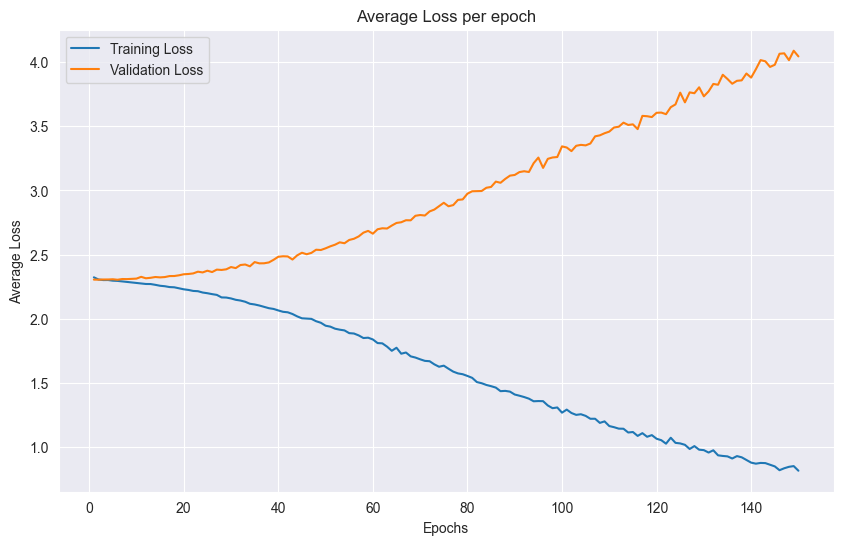

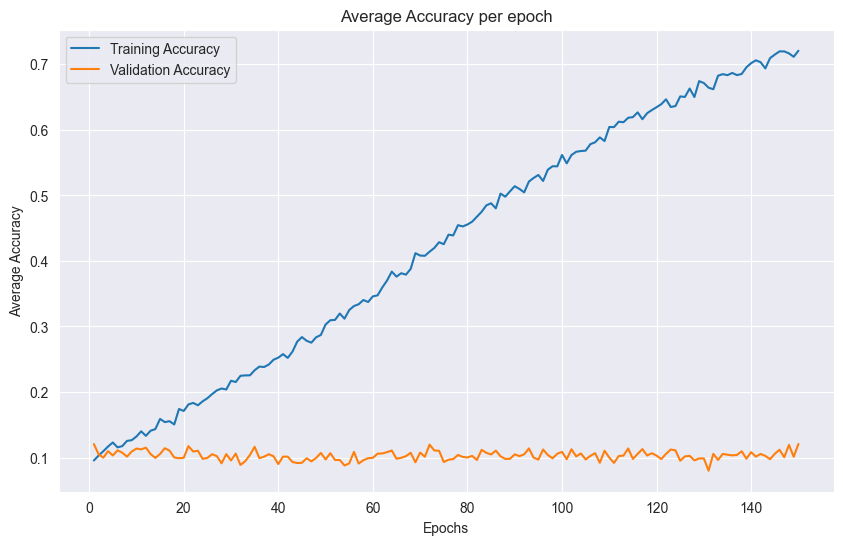

Overall Accuracy: 0.094


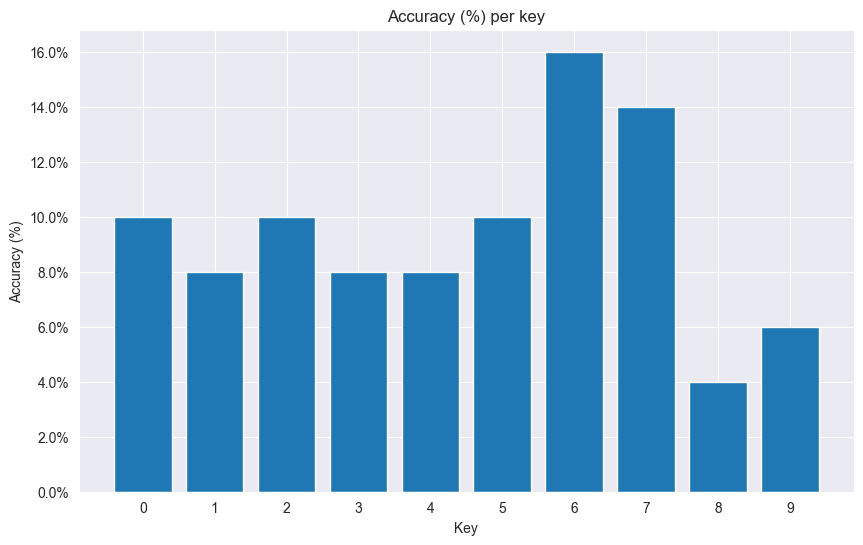

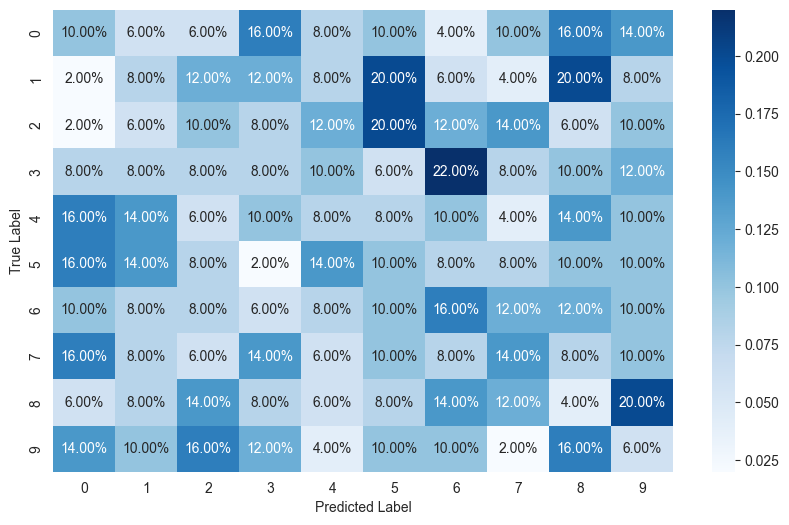

Accuracy for each key: 0: 10.0% 1: 8.0% 2: 10.0% 3: 8.0% 4: 8.0% 5: 10.0% 6: 16.0% 7: 14.0% 8: 4.0% 9: 6.0% 
              precision    recall  f1-score   support

           0       0.10      0.10      0.10        50
           1       0.09      0.08      0.08        50
           2       0.11      0.10      0.10        50
           3       0.08      0.08      0.08        50
           4       0.10      0.08      0.09        50
           5       0.09      0.10      0.09        50
           6       0.15      0.16      0.15        50
           7       0.16      0.14      0.15        50
           8       0.03      0.04      0.04        50
           9       0.05      0.06      0.06        50

    accuracy                           0.09       500
   macro avg       0.10      0.09      0.09       500
weighted avg       0.10      0.09      0.09       500

                    Model Parameters                    
Layer                    | Parameters
conv1d.weight            : 64 * 1 * 3

In [49]:
def main():
    # setup parameters and load data
    batch_size = 64
    epochs = 150
    number_of_categories = 10
    
    X_train, X_val, X_test, y_train, y_val, y_test = importData()
    trainDataset = CSIDataset(X_train, y_train)
    valDataset = CSIDataset(X_val, y_val)
    
    trainLoader = DataLoader(trainDataset, shuffle=True, batch_size=batch_size)
    valLoader = DataLoader(valDataset, shuffle=True, batch_size=batch_size)

    lr = [0.001, 0.0001, 0.00001]
    model = CNN1D(number_of_categories)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    loss = nn.CrossEntropyLoss()
    train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
    plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
    
    # if (os.path.isfile("model.pth")):
    #     model.load_state_dict(torch.load('model.pth'))
    # else:
    #     train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
    #     # save the model
    #     torch.save(model.state_dict(), 'model.pth')
    #     plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
        
    # output = []
    # for i in range(len(lr)):
    #     model = CNN1D(number_of_categories)
    #     optimizer = optim.Adam(model.parameters(), lr=lr[i], weight_decay=0.0001)
    #     loss = nn.CrossEntropyLoss()
    #     train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
    #     output.append(eval_acc_list)
    #     
    # fig, acc = plt.subplots(figsize=(10,6))
    # x = [i for i in range(1, epochs+1)]
    # for i in range(len(output)):
    #     acc.plot(x, [trainAcc.item() for trainAcc in output[i]])
    # plt.legend()
    # plt.show()
    
    # plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
    # torch.save(model.state_dict(), 'model_denoised_butter.pth')
    
    # Simple check with test dataset
    model.eval()
    testDataset = CSIDataset(X_test, y_test)
    testLoader = DataLoader(testDataset, shuffle=True, batch_size=X_test.shape[0])
    test(model, testLoader, X_test.shape[0])
    
    print_model_parameters(model)
    
main()

In [48]:
model = CNN1D(10)
model.load_state_dict(torch.load('model_denoised_butter.pth'))
model.eval()

k = 3
extension = ".npy"
for file in os.listdir("../data/real_env"):
    if file.endswith(extension):
        print("========" + file + "========")
        y_batch = torch.tensor([[int(i)] for i in file.split("_")[0]], dtype=torch.float32)
        X_batch = torch.tensor(np.load("../data/real_env_denoised_butter/" + file), dtype=torch.float32)
        
        y_batch = y_batch.type(torch.LongTensor).squeeze(1)
        logits = model(X_batch)
        y_pred = F.log_softmax(logits, dim=1)
        
        predicted = np.argmax(y_pred.cpu().detach().numpy(), axis=1)
        print(f"Actual: " + f"{y_batch.tolist()}" + " Predicted: " f"{predicted}")
        values, indices = y_pred.topk(k)
        transposed_indx = torch.transpose(indices, 0, 1)
        print(f"Top k predictions: \n{transposed_indx.tolist()}")

RuntimeError: Error(s) in loading state_dict for CNN1D:
	Missing key(s) in state_dict: "conv1d.weight", "conv1d.bias", "conv1d_2.weight", "conv1d_2.bias", "conv1d_3.weight", "conv1d_3.bias", "batch_norm.weight", "batch_norm.bias", "batch_norm.running_mean", "batch_norm.running_var", "batch_norm_2.weight", "batch_norm_2.bias", "batch_norm_2.running_mean", "batch_norm_2.running_var", "batch_norm_3.weight", "batch_norm_3.bias", "batch_norm_3.running_mean", "batch_norm_3.running_var", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "conv1.bias", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.conv1.bias", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.conv2.weight", "layer1.0.conv2.bias", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer1.1.conv1.weight", "layer1.1.conv1.bias", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.conv2.weight", "layer1.1.conv2.bias", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.num_batches_tracked", "layer2.0.conv1.weight", "layer2.0.conv1.bias", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.conv2.weight", "layer2.0.conv2.bias", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer2.0.identity_downsample.0.weight", "layer2.0.identity_downsample.0.bias", "layer2.0.identity_downsample.1.weight", "layer2.0.identity_downsample.1.bias", "layer2.0.identity_downsample.1.running_mean", "layer2.0.identity_downsample.1.running_var", "layer2.0.identity_downsample.1.num_batches_tracked", "layer2.1.conv1.weight", "layer2.1.conv1.bias", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.conv2.weight", "layer2.1.conv2.bias", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.num_batches_tracked", "layer3.0.conv1.weight", "layer3.0.conv1.bias", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.conv2.weight", "layer3.0.conv2.bias", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "layer3.0.identity_downsample.0.weight", "layer3.0.identity_downsample.0.bias", "layer3.0.identity_downsample.1.weight", "layer3.0.identity_downsample.1.bias", "layer3.0.identity_downsample.1.running_mean", "layer3.0.identity_downsample.1.running_var", "layer3.0.identity_downsample.1.num_batches_tracked", "layer3.1.conv1.weight", "layer3.1.conv1.bias", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.conv2.weight", "layer3.1.conv2.bias", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.num_batches_tracked", "layer4.0.conv1.weight", "layer4.0.conv1.bias", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.conv2.bias", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.identity_downsample.0.weight", "layer4.0.identity_downsample.0.bias", "layer4.0.identity_downsample.1.weight", "layer4.0.identity_downsample.1.bias", "layer4.0.identity_downsample.1.running_mean", "layer4.0.identity_downsample.1.running_var", "layer4.0.identity_downsample.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.conv1.bias", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.conv2.bias", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked", "fc.weight", "fc.bias". 

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = importData()

# stack all the samples together
X_train = np.append(X_train, X_val, axis=0)
y_train = np.append(y_train, y_val, axis=0)

X_train = np.append(X_train, X_test, axis=0)
y_train = np.append(y_train, y_test, axis=0)

X_train, y_train = shuffle(X_train, y_train)
tsne = TSNE(n_components=2, verbose=1, random_state=123, perplexity=10, learning_rate=10, early_exaggeration=1)
print(X_train.shape)
X_train = np.reshape(X_train, [X_train.shape[0], X_train.shape[1]*X_train.shape[2]])
print(X_train.shape)

z = tsne.fit_transform(X_train)

df = pd.DataFrame()
y_train = y_train.flatten()
df["y"] = y_train.tolist()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", 10)).set(title="Amplitude data T-SNE projection")